Displaying a sample image...


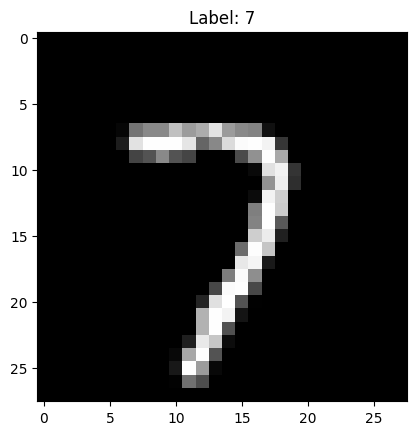


Training the model...
Epoch [1/5], Step [100/600], Loss: 0.2621
Epoch [1/5], Step [200/600], Loss: 0.2793
Epoch [1/5], Step [300/600], Loss: 0.2092
Epoch [1/5], Step [400/600], Loss: 0.2058
Epoch [1/5], Step [500/600], Loss: 0.0835
Epoch [1/5], Step [600/600], Loss: 0.1211
Epoch [2/5], Step [100/600], Loss: 0.1105
Epoch [2/5], Step [200/600], Loss: 0.1280
Epoch [2/5], Step [300/600], Loss: 0.1569
Epoch [2/5], Step [400/600], Loss: 0.0757
Epoch [2/5], Step [500/600], Loss: 0.0810
Epoch [2/5], Step [600/600], Loss: 0.0649
Epoch [3/5], Step [100/600], Loss: 0.0660
Epoch [3/5], Step [200/600], Loss: 0.0469
Epoch [3/5], Step [300/600], Loss: 0.0259
Epoch [3/5], Step [400/600], Loss: 0.1263
Epoch [3/5], Step [500/600], Loss: 0.1405
Epoch [3/5], Step [600/600], Loss: 0.0622
Epoch [4/5], Step [100/600], Loss: 0.1025
Epoch [4/5], Step [200/600], Loss: 0.0455
Epoch [4/5], Step [300/600], Loss: 0.0326
Epoch [4/5], Step [400/600], Loss: 0.1138
Epoch [4/5], Step [500/600], Loss: 0.0515
Epoch [4/5]

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(torch.randint(0, 10000, (1,)).item()) # change this if you want a manual seed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparameters
input_size = 784  # 28x28
hidden_size = 128
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# MNIST dataset
class MNIST(torchvision.datasets.MNIST):
    resources = [
        ('https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz',
         'f68b3c2dcbeaaa9fbdd348bbdeb94873'),
        ('https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz',
         'd53e105ee54ea40749a09fcbcd1e9432'),
        ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz',
         '9fb629c4189551a2d022fa330f9573f3'),
        ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz',
         'ec29112dd5afa0611ce80d1b7f02629c')
    ]

# loading data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# neutral network!
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.reshape(-1, 28*28)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# loss / optimize
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# show sample
def visualize_sample(loader):
    examples = iter(loader)
    example_data, example_targets = next(examples)
    img = example_data[0].squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(f'Label: {example_targets[0]}')
    plt.show()

# training
def train_model():
    n_total_steps = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

# testing
def test_model():
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(10)]
        n_class_samples = [0 for i in range(10)]

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            # max returns (value, index)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            for i in range(batch_size):
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {acc} %')

        for i in range(10):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of digit {i}: {acc} %')

if __name__ == '__main__':
    # showing sample
    print("Displaying a sample image...")
    visualize_sample(train_loader)

    # training
    print("\nTraining the model...")
    train_model()

    # testing
    print("\nTesting the model...")
    test_model()